<a href="https://colab.research.google.com/github/Deep-Learning-Assignment/Deep-Learning-Project/blob/IT21161742_Kumari-P.D.L/PlantVillage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
import os
from google.colab import drive
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Mount Google Drive
drive.mount('/content/drive')

# Path to dataset zip file in Google Drive
zip_file_path = '/content/drive/My Drive/Plant Village.zip'

# Directory to extract the files
extract_dir = '/content/Extracted_data'

# Create directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Dataset extracted to {extract_dir}")

Mounted at /content/drive
Dataset extracted to /content/Extracted_data


In [2]:
!pip install split-folders

In [3]:
import splitfolders

# Path to the folder where your dataset is located
input_folder = '/content/Extracted_data/PlantVillage'

# Split dataset into train (70%), validation (20%), and test (10%)
splitfolders.ratio(input_folder, output="/content/split_data", seed=42, ratio=(.7, .2, .1))

print("Dataset has been split into training, validation, and test sets.")


Copying files: 20639 files [00:02, 6974.53 files/s]

Dataset has been split into training, validation, and test sets.


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [5]:
# Create an ImageDataGenerator for the training set with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,       # Normalize pixel values to [0, 1]
    rotation_range=20,    # Randomly rotate images by 40 degrees
    width_shift_range=0.2, # Shift the image horizontally by 20%
    height_shift_range=0.2, # Shift the image vertically by 20%
    shear_range=0.2,      # Apply shearing transformations
    zoom_range=0.2,       # Randomly zoom in on images
    horizontal_flip=True, # Flip images horizontally
    fill_mode='nearest'   # Fill any missing pixels after rotation/shift with nearest pixel
)

# Create ImageDataGenerator for validation and test sets (only rescale the images)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Define the directories for train, validation, and test sets
train_dir = '/content/split_data/train'
val_dir = '/content/split_data/val'
test_dir = '/content/split_data/test'

# Load the images and resize them to 224x224 (standard input size for VGG16)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Resize to 224x224
    batch_size=64,           # Batch size
    class_mode='categorical',
    shuffle=True  # Randomly shuffle the images for each epoch
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)


Found 14440 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.
Found 2076 images belonging to 15 classes.


In [6]:
num_classes = train_generator.num_classes  # Should return the number of classes
print(f"Number of classes: {num_classes}")

num_classes = 15  # Set this to the actual number of classes


Number of classes: 15


In [7]:
batch = next(train_generator)

# Print the shape of the images and labels
print(f"Batch image shape: {batch[0].shape}")  # This should be (batch_size, 224, 224, 3)
print(f"Batch label shape: {batch[1].shape}")

Batch image shape: (64, 224, 224, 3)
Batch label shape: (64, 15)


In [8]:
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import AdamW  # Use AdamW optimizer
from tensorflow.keras.callbacks import ReduceLROnPlateau
import numpy as np
from sklearn.utils import class_weight  # Import the class_weight module from sklearn
from tensorflow.keras.regularizers import l2

# Assuming your train dataset is loaded in train_generator
# Compute class weights based on your training dataset
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weights_dict = dict(enumerate(class_weights))

# Define the input shape
input_tensor = Input(shape=(224, 224, 3))

# Load the VGG16 model pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)

# Freeze the first 30 layers
for layer in base_model.layers[:15]:
    layer.trainable = False

# Build the model
x = Flatten()(base_model.output)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)  # L2 regularization
x = BatchNormalization()(x)  # Add Batch Normalization
x = Dropout(0.6)(x)  # Add a Dropout layer

# Additional Dense layer
x = Dense(128, activation='relu')(x)  # New additional fully connected layer
x = BatchNormalization()(x)  # Add Batch Normalization
x = Dropout(0.5)(x)  # Add another Dropout layer

# Output layer
num_classes = len(class_weights)  # Ensure this matches your number of classes
output = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Print the model summary
model.summary()

# Compile the model with AdamW optimizer
optimizer = AdamW(learning_rate=0.0005, weight_decay=0.001)  # AdamW with weight decay

import tensorflow as tf
from tensorflow.keras import backend as K

# Define F1 Score as a custom metric
def f1_score(y_true, y_pred):
    y_pred = K.round(y_pred)  # Round predictions to 0 or 1
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)  # True positives
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)  # False positives
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)  # False negatives

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    return K.mean(f1)  # Mean F1 score across all classes

from tensorflow.keras.metrics import TopKCategoricalAccuracy

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', TopKCategoricalAccuracy(k=5), f1_score])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,173,839 (80.77 MB)

 Trainable params: 13,537,807 (51.64 MB)

 Non-trainable params: 7,636,032 (29.13 MB)

In [9]:
# # Set up a learning rate scheduler
# from tensorflow.keras.callbacks import ReduceLROnPlateau

# # Create a learning rate scheduler
# lr_scheduler = ReduceLROnPlateau(
#     monitor='val_accuracy', # Monitor validation accuracy
#     factor=0.5,            # Reduce learning rate by half
#     patience=3,            # Wait for 3 epochs before reducing
#     min_lr=1e-6            # Minimum learning rate
# )

# # Train the model
# history = model.fit(
#     train_generator,
#     validation_data=val_generator,
#     epochs=15,              # Set the number of epochs
#     callbacks=[lr_scheduler] # Add the learning rate scheduler
# )


In [10]:
# Updated ReduceLROnPlateau Scheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau  # Removed EarlyStopping import

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
)

# Train the model and track accuracy, F1 score, and top-k accuracy
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[lr_scheduler]
)


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


226/226 ━━━━━━━━━━━━━━━━━━━━ 215s 813ms/step - accuracy: 0.3360 - f1_score: 0.1819 - loss: 4.9248 - top_k_categorical_accuracy: 0.6904 - val_accuracy: 0.6735 - val_f1_score: 0.4982 - val_loss: 1.9619 - val_top_k_categorical_accuracy: 0.9486 - learning_rate: 5.0000e-04
Epoch 2/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 165s 707ms/step - accuracy: 0.6809 - f1_score: 0.4754 - loss: 1.7568 - top_k_categorical_accuracy: 0.9545 - val_accuracy: 0.7387 - val_f1_score: 0.5715 - val_loss: 1.2733 - val_top_k_categorical_accuracy: 0.9566 - learning_rate: 5.0000e-04
Epoch 3/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 164s 704ms/step - accuracy: 0.7870 - f1_score: 0.6267 - loss: 1.0351 - top_k_categorical_accuracy: 0.9822 - val_accuracy: 0.7094 - val_f1_score: 0.5235 - val_loss: 1.2966 - val_top_k_categorical_accuracy: 0.9515 - learning_rate: 5.0000e-04
Epoch 4/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 164s 702ms/step - accuracy: 0.8356 - f1_score: 0.7058 - loss: 0.7445 - top_k_categorical_accuracy: 0.9907 - val_accuracy: 0.8319 - 

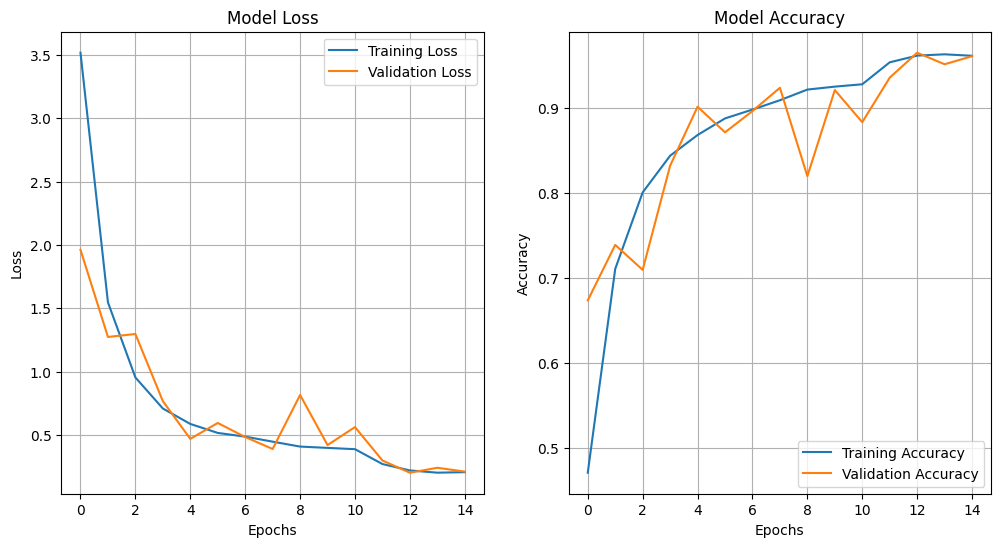

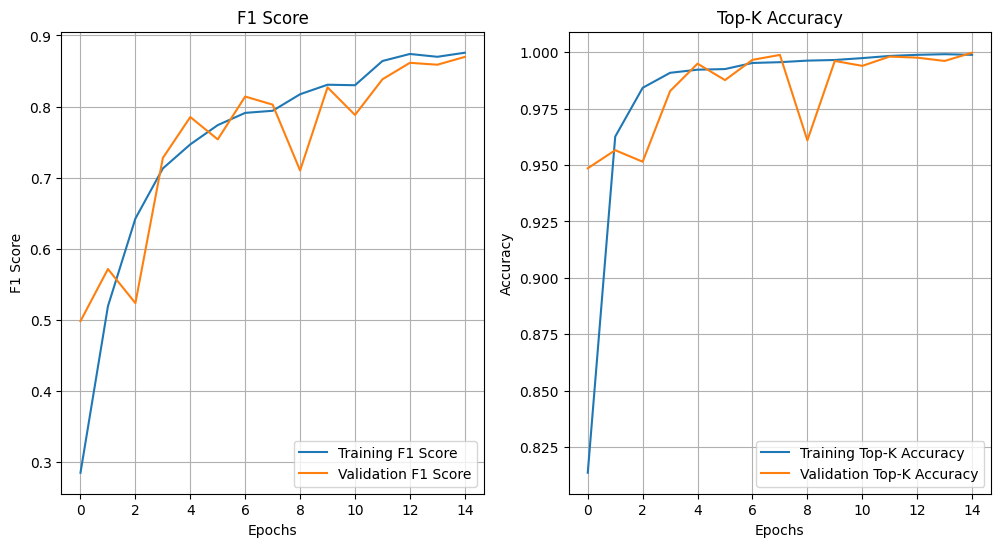

In [11]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid()

plt.show()

# Plot F1 score and Top-K accuracy (if you want separate graphs for these metrics)
plt.figure(figsize=(12, 6))

# F1 Score plot
plt.subplot(1, 2, 1)
plt.plot(history.history['f1_score'], label='Training F1 Score')
plt.plot(history.history['val_f1_score'], label='Validation F1 Score')
plt.title('F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend(loc='lower right')
plt.grid()

# Top-K accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['top_k_categorical_accuracy'], label='Training Top-K Accuracy')
plt.plot(history.history['val_top_k_categorical_accuracy'], label='Validation Top-K Accuracy')
plt.title('Top-K Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid()

plt.show()


In [12]:
# Evaluate the model on the test set
test_loss, test_accuracy, test_topk_accuracy, test_f1_score = model.evaluate(test_generator)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Top-5 Accuracy: {test_topk_accuracy}")
print(f"Test F1 Score: {test_f1_score}")


33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 434ms/step - accuracy: 0.9599 - f1_score: 0.8857 - loss: 0.2230 - top_k_categorical_accuracy: 0.9952
Test Loss: 0.20486828684806824
Test Accuracy: 0.9643545150756836
Test Top-5 Accuracy: 0.997591495513916
Test F1 Score: 0.876840353012085


In [13]:
# Save the model to a file
model.save('food_disease_classification_model.h5')
print("Model saved successfully.")

Model saved successfully.


In [14]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [15]:
# Load the trained model
model = load_model('food_disease_classification_model.h5')


In [16]:
def preprocess_image(image_path):
    # Load the image with the target size for VGG16
    image = load_img(image_path, target_size=(224, 224))
    # Convert the image to a numpy array
    image = img_to_array(image)
    # Scale the pixel values to [0, 1]
    image = image / 255.0
    # Expand dimensions to match the model input
    image = np.expand_dims(image, axis=0)
    return image


In [17]:
def predict_image(image_path):
    # Preprocess the image
    processed_image = preprocess_image(image_path)
    # Make predictions
    predictions = model.predict(processed_image)
    # Get the predicted class
    predicted_class = np.argmax(predictions, axis=1)[0]
    return predicted_class


In [18]:
import os

def get_class_names(data_dir):
    class_names = sorted([folder for folder in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, folder))])
    return class_names

# Usage
data_dir = '/content/Extracted_data/PlantVillage'  # Replace with the path to your dataset directory
class_names = get_class_names(data_dir)

print("Class names:", class_names)

Class names: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [19]:
# Replace these with your actual class names based on the folder structure
Class_names: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']  # Add all classes

def get_class_name(class_index):
    return class_names[class_index]


In [20]:
# Path to the test image
image_path = '/content/split_data/test/Tomato_Spider_mites_Two_spotted_spider_mite/09dce947-bb58-46cc-bd33-5a5e75ee07f4___Com.G_SpM_FL 9019.JPG'  # Replace with your image path

# Get predicted class index
predicted_class_index = predict_image(image_path)
# Get predicted class name
predicted_class_name = get_class_name(predicted_class_index)

print(f"Predicted class: {predicted_class_name}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted class: Tomato_Spider_mites_Two_spotted_spider_mite
